In [1]:
import pandas as pd
from pathlib import Path
from shutil import copy

## Might want to look into wakepy to prevent the machine from sleeping overnight when running models

In [ ]:
from wakepy import keep

with keep.running():
    # code here
    print("Running script...")

In [2]:
#Import and add "gr" variable
t1 = pd.read_csv('cat19.csv')

t1['gr'] = t1['g_cmodel_mag'] - t1['r_cmodel_mag']

print(t1.head()['gr'])

0    0.973304
1    0.413082
2    0.882370
3    0.981340
4    1.191181
Name: gr, dtype: float64


In [3]:
#Filter dataframe down to 1000 samples that are 99% predicted to be oval1 and most likely red
t1_filtered = t1[(t1['oval1'] > 0.99) & (t1['gr'] > 0.75)].sample(n=1000)

In [4]:
#Create temp folder for red ovals
source_folder = Path('ims')
dest_folder = Path('tmp_red')
dest_folder.mkdir(exist_ok=True)

In [5]:
#Copy images to folder
for image_id in t1_filtered['Unnamed: 0']:
    src_file = source_folder / f"{image_id}.png"
    dst_file = dest_folder / f"{image_id}.png"
    if src_file.exists():
        copy(src_file, dst_file)
    else:
        print(f"Image {src_file} not found.")

In [ ]:
#Repeat above process for blue ovals (condensed to one cell)

#Filter dataframe down to 1000 samples that are 99% predicted to be oval1 and most likely blue
t1_filtered = t1[(t1['oval1'] > 0.99) & (t1['gr'] < 0.55)].sample(n=1000)

#Create temp folder for blue ovals
source_folder = Path('ims')
dest_folder = Path('tmp_blue')
dest_folder.mkdir(exist_ok=True)

#Copy images to folder
for image_id in t1_filtered['Unnamed: 0']:
    src_file = source_folder / f"{image_id}.png"
    dst_file = dest_folder / f"{image_id}.png"
    if src_file.exists():
        copy(src_file, dst_file)
    else:
        print(f"Image {src_file} not found.")

In [1]:
from fastai.vision.all import *
from sklearn.model_selection import train_test_split

#ONLY USE BELOW CODE IF USING GPU FOR ADDITONAL HORSEPOWER
print(torch.cuda.is_available())  # Should print True if GPU is enabled
print(torch.cuda.get_device_name(0))  # Shows the name of your GPU

True


In [4]:
#Split test and train data randomly for red and blue ovals
source_folder = Path('ims')
classes = ['xblue', 'xred']

for cls in classes:
    img_path = source_folder / cls
    images = list(img_path.iterdir())
    
    # Split into train and valid
    train_imgs, valid_imgs = train_test_split(images, test_size=0.2, random_state=42)

    # Create target folders
    (source_folder / 'train' / cls).mkdir(parents=True, exist_ok=True)
    (source_folder / 'valid' / cls).mkdir(parents=True, exist_ok=True)

    # Move images
    for img in train_imgs:
        shutil.copy(str(img), str(source_folder / 'train' / cls / img.name))
    for img in valid_imgs:
        shutil.copy(str(img), str(source_folder / 'valid' / cls / img.name))



In [6]:
#Load tested data
dls = ImageDataLoaders.from_folder(
    source_folder, 
    train='train', 
    vald='valid',
    num_workers=12, #Sets CPU to use 12 cores (I am using a Ryzen 9 5900X with 12 cores) 
    bs=64, #Sets batch size to 128 to leverage GPU in processing by increasing batch size
    pin_memory=True #Improves data transfer between CPU and GPU
) 
#, item_tfms=Resize(224)) #Resize images (speeds up model but decreases accuracy because image looks worse)

#Create model
learn = vision_learner(dls, resnet34, metrics=accuracy)

SuggestedLRs(valley=0.00363078061491251)


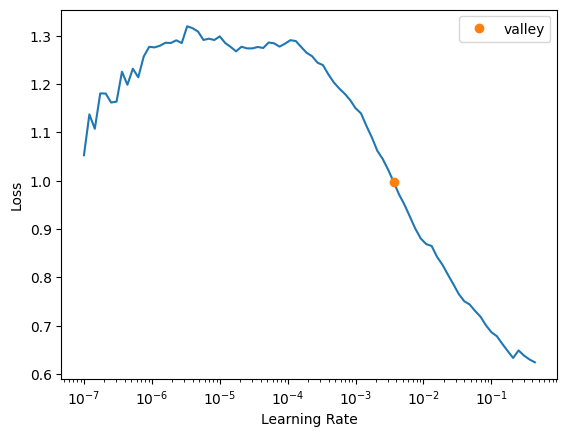

In [14]:
#Find optimal learning value
#Unused in this model
optimal_model = learn.lr_find()
print(optimal_model)
optimal_rate = optimal_model[0]

In [16]:
#Fine tune
learn.fine_tune(4)

epoch,train_loss,valid_loss,accuracy,time
0,0.554296,0.227553,0.911458,00:25


epoch,train_loss,valid_loss,accuracy,time
0,0.153837,0.087475,0.976042,00:25
1,0.086522,0.074813,0.982292,00:25
2,0.042704,0.069972,0.984375,00:25
3,0.019723,0.072129,0.982292,00:25


In [17]:
#Evaluate
learn.validate()

(#2) [0.07212904840707779,0.9822916388511658]

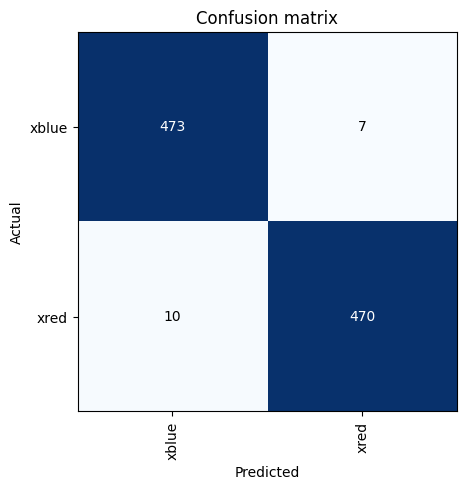

In [18]:
#Evaluate model
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()


In [44]:
#Save classifier
learn.export('oval_model1.pkl')

# Run training with convnext-tiny

In [33]:
#TEST WITH NEW ARCHITECTURE

#Load tested data
dls = ImageDataLoaders.from_folder(
    source_folder, 
    train='train', 
    vald='valid',
    num_workers=12, #Sets CPU to use 12 cores (I am using a Ryzen 9 5900X with 12 cores) 
    bs=64, #Sets batch size to leverage GPU in processing by increasing batch size
    pin_memory=True #Improves data transfer between CPU and GPU
) 
#, item_tfms=Resize(224)) #Resize images (speeds up model but decreases accuracy because image looks worse)

#Create model
learn = vision_learner(dls, convnext_tiny, metrics=accuracy)

C:\Users\evnpu\anaconda3\envs\pytorch_env\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\evnpu\anaconda3\envs\pytorch_env\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Tiny_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/convnext_tiny-983f1562.pth" to C:\Users\evnpu/.cache\torch\hub\checkpoints\convnext_tiny-983f1562.pth
100%|███████████████████████████████████████████████████████████████████████████████| 109M/109M [00:04<00:00, 24.7MB/s]


SuggestedLRs(valley=0.0014454397605732083)


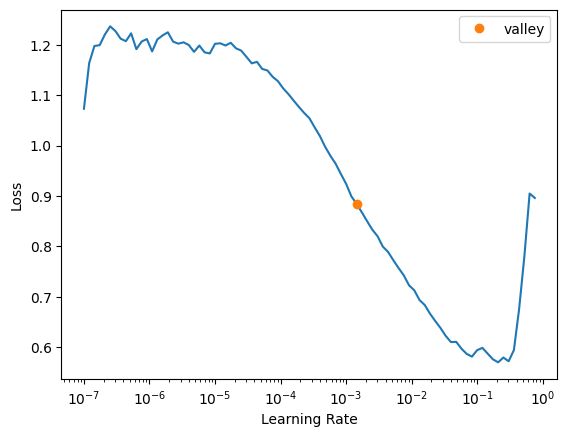

In [34]:
#Find optimal learning value
optimal_model = learn.lr_find()
print(optimal_model)
optimal_rate = optimal_model[0]

In [35]:
#Fine tune
learn.fine_tune(4, base_lr = optimal_rate)

epoch,train_loss,valid_loss,accuracy,time
0,0.383338,0.099803,0.968750,01:11


epoch,train_loss,valid_loss,accuracy,time
0,0.158594,0.084516,0.969792,04:42
1,0.106395,0.070628,0.982292,04:43
2,0.084119,0.047570,0.989583,04:23
3,0.068071,0.048479,0.988542,04:24


In [36]:
#Evaluate
learn.validate()

(#2) [0.04847854748368263,0.9885416626930237]

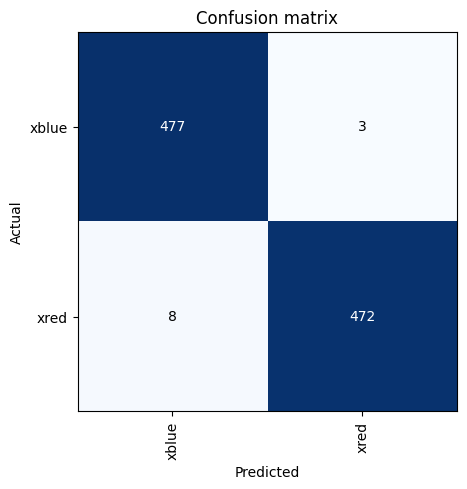

In [37]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

# Try convnext small just for fun

In [39]:
#TEST WITH NEW ARCHITECTURE

#Load tested data
dls = ImageDataLoaders.from_folder(
    source_folder, 
    train='train', 
    vald='valid',
    num_workers=12, #Sets CPU to use 12 cores (I am using a Ryzen 9 5900X with 12 cores) 
    bs=64, #Sets batch size to leverage GPU in processing by increasing batch size
    pin_memory=True #Improves data transfer between CPU and GPU
) 
#, item_tfms=Resize(224)) #Resize images (speeds up model but decreases accuracy because image looks worse)

#Create model
learn = vision_learner(dls, convnext_small, metrics=accuracy)

C:\Users\evnpu\anaconda3\envs\pytorch_env\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\evnpu\anaconda3\envs\pytorch_env\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ConvNeXt_Small_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/convnext_small-0c510722.pth" to C:\Users\evnpu/.cache\torch\hub\checkpoints\convnext_small-0c510722.pth
100%|███████████████████████████████████████████████████████████████████████████████| 192M/192M [00:07<00:00, 25.2MB/s]


SuggestedLRs(valley=0.002511886414140463)


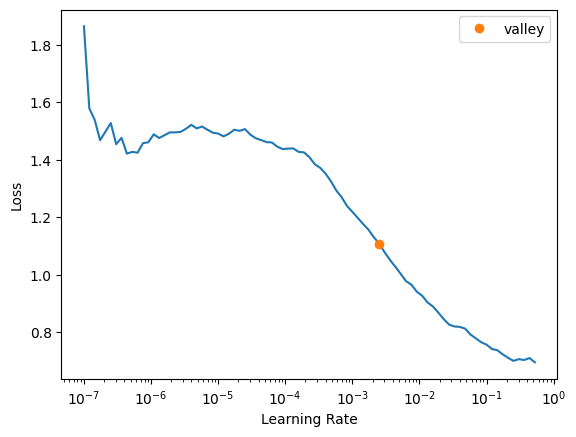

In [40]:
#Find optimal learning value
optimal_model = learn.lr_find()
print(optimal_model)
optimal_rate = optimal_model[0]

In [41]:
#Fine tune
learn.fine_tune(3, base_lr = optimal_rate)

epoch,train_loss,valid_loss,accuracy,time
0,0.442817,0.097092,0.963542,03:09


epoch,train_loss,valid_loss,accuracy,time
0,0.155914,0.059380,0.982292,9:12:03
1,0.126307,0.060884,0.980208,39:35
2,0.082251,0.047173,0.986458,40:13


In [42]:
#Evaluate
learn.validate()

(#2) [0.04717293754220009,0.9864583611488342]

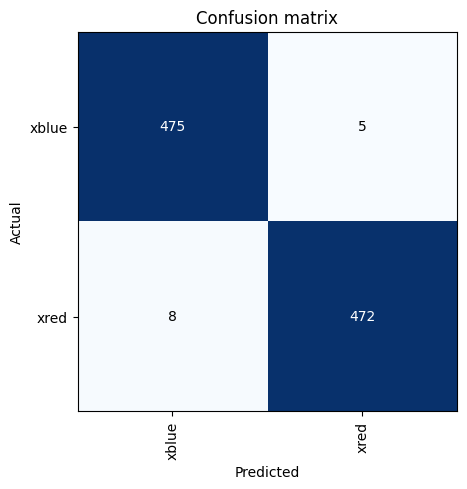

In [43]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()